In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Ustawienia dla modelu
batch_size = 64
learning_rate = 0.01
epochs = 10

In [17]:
# Przygotowanie zbioru danych
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # Normalizacja

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Definicja modelu
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Spłaszczenie do wektora
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Inicjalizacja modelu, optymalizatora i funkcji kosztu
model = FashionMNISTClassifier()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [19]:
# Funkcja treningowa
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
            )


# Funkcja testowa
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({accuracy:.0f}%)\n"
    )


# Wykonanie treningu i testowania modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch: 1 [0/60000 (0%)]	Loss: 2.304866
Epoch: 1 [6400/60000 (11%)]	Loss: 0.698769
Epoch: 1 [12800/60000 (21%)]	Loss: 0.479668
Epoch: 1 [19200/60000 (32%)]	Loss: 0.482168
Epoch: 1 [25600/60000 (43%)]	Loss: 0.284556
Epoch: 1 [32000/60000 (53%)]	Loss: 0.310983
Epoch: 1 [38400/60000 (64%)]	Loss: 0.351565
Epoch: 1 [44800/60000 (75%)]	Loss: 0.533133
Epoch: 1 [51200/60000 (85%)]	Loss: 0.434451
Epoch: 1 [57600/60000 (96%)]	Loss: 0.442495

Test set: Average loss: 0.0056, Accuracy: 8715/10000 (87%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.208318
Epoch: 2 [6400/60000 (11%)]	Loss: 0.385058
Epoch: 2 [12800/60000 (21%)]	Loss: 0.432976
Epoch: 2 [19200/60000 (32%)]	Loss: 0.319580
Epoch: 2 [25600/60000 (43%)]	Loss: 0.166559
Epoch: 2 [32000/60000 (53%)]	Loss: 0.401068
Epoch: 2 [38400/60000 (64%)]	Loss: 0.395381
Epoch: 2 [44800/60000 (75%)]	Loss: 0.283877
Epoch: 2 [51200/60000 (85%)]	Loss: 0.315256
Epoch: 2 [57600/60000 (96%)]	Loss: 0.249415

Test set: Average loss: 0.0053, Accuracy: 8812/10000 (88%)

Epoch: 3 [

### Ex.2 - Autoencoder

In [20]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [22]:
# Przygotowanie zbioru danych
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # Normalizacja

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [23]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)  # Flatten the images

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# Visualize some reconstructed images
def show_reconstructed_images(model, data_loader):
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            outputs = model(images_flat)
            outputs = outputs.view(images.size(0), 1, 28, 28)

            # Plot original and reconstructed images
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(images[0].cpu().squeeze(), cmap="gray")
            axes[0].set_title("Original")
            axes[1].imshow(outputs[0].cpu().squeeze(), cmap="gray")
            axes[1].set_title("Reconstructed")
            plt.show()
            break

Epoch [1/10], Loss: 0.6635
Epoch [2/10], Loss: 0.6220
Epoch [3/10], Loss: 0.6250
Epoch [4/10], Loss: 0.5975
Epoch [5/10], Loss: 0.5742
Epoch [6/10], Loss: 0.6107
Epoch [7/10], Loss: 0.5919
Epoch [8/10], Loss: 0.5371
Epoch [9/10], Loss: 0.5695
Epoch [10/10], Loss: 0.5999


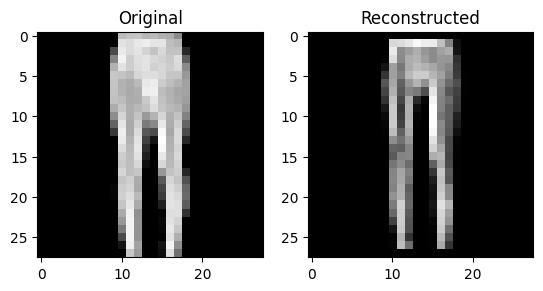

In [26]:
show_reconstructed_images(model, train_loader)

#### Ex.3 - Audio

In [27]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.1+cpu
2.5.1+cpu
cpu


In [28]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = r"C:\Users\Jan\Downloads\We Need To Build A Wall.mp3"

In [29]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [30]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [31]:
IPython.display.Audio(SPEECH_FILE)

In [32]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [33]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

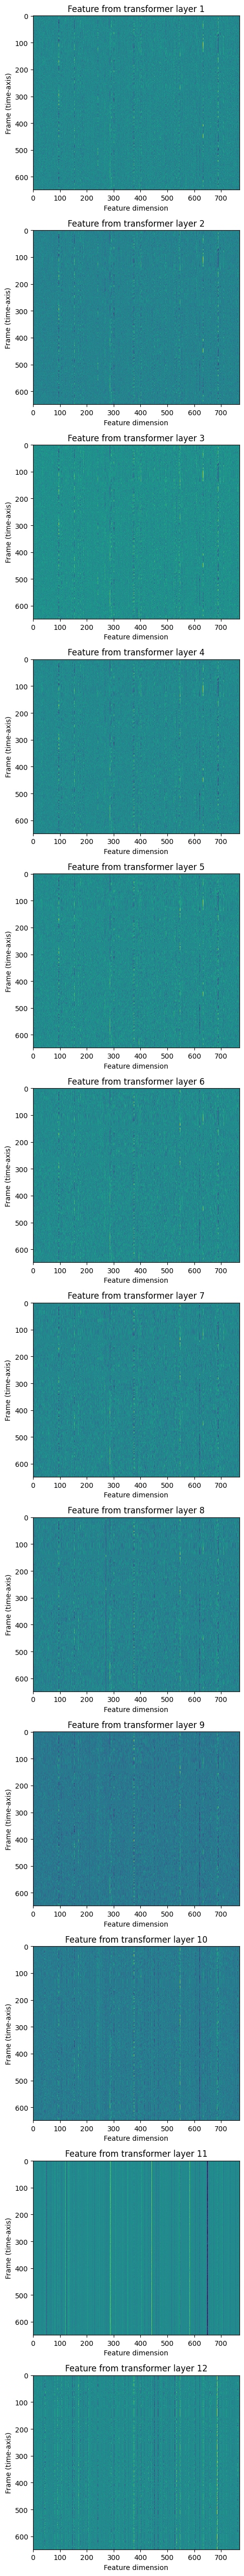

In [34]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [35]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


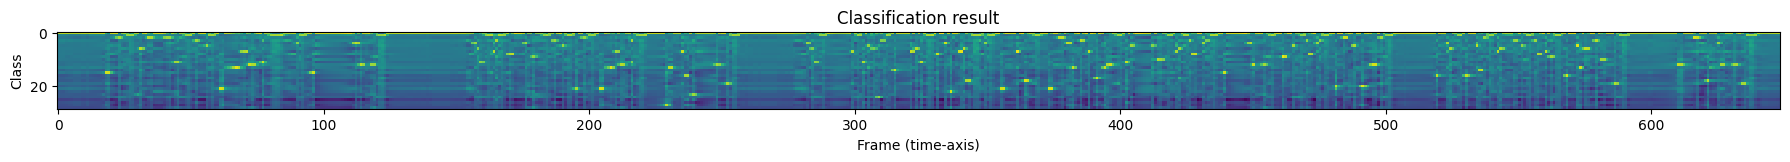

In [36]:
plt.figure(figsize=(18, 12))
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [37]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [38]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [39]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

WE|NEED|TO|BUILD|A|WALL|AND|IT|HAS|TO|BE|BUILT|QUICKLY|AND|I|DON'T|MIND|HAVING|A|BIG|BEAUTIFUL|DOOR|IN|THAT|WALL|SO|THAT|PEOPLE|CAN|COME|INTO|THIS|COUNTRY|LEGALLY|
